In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
source_path = "/content/drive/MyDrive/Lab2_Dataset/daily+and+sports+activities for pattern project.zip"
destination_path = "/content"
import zipfile

with zipfile.ZipFile(source_path, 'r') as zip_ref:
  zip_ref.extractall(destination_path)

In [113]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from math import log2
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# ***Loading Dataset***

In [158]:
def load_data(root_directory="data"):
    data = []
    labels = []
    for Dir_path, dir_names, file_names in os.walk(root_directory):
        dir_names.sort()
        file_names.sort()
        for file_name in file_names:
            file_path = os.path.join(Dir_path, file_name)
            segment = np.loadtxt(file_path, delimiter=',', skiprows=0, max_rows=125)
            parts = Dir_path.split(os.path.sep)[-2:]
            label = int(parts[0][-2:])
            data.append(segment)
            labels.append(label)
    return train_test_split(np.array(data), np.array(labels), train_size=.8, shuffle=False)

In [117]:
def scale_data(training_data, test_data):
    scaler = MinMaxScaler()
    training_data_normalized = scaler.fit_transform(training_data)
    test_data_normalized = scaler.transform(test_data)
    return training_data_normalized, test_data_normalized

### Generating The Dataset (Method 1):
Taking The mean of each column in each segment Resulting in 45 features for each data point

In [154]:
def taking_segment_mean(training_data, test_data):
    training_data_after_mean = np.array([np.mean(segment, axis=0) for segment in training_data])
    test_data_after_mean = np.array([np.mean(segment, axis=0) for segment in test_data])
    return training_data_after_mean, test_data_after_mean

### Generating The Dataset (Method 2):
Flattening all the features together in 45 x 125 = 5625 features for each
data point, Then Reducing the resulted dimensions.
We use alpha equals 0.95 after reduction it gives 299 components

In [166]:
def applying_pca(training_data, test_data):
    pca = PCA(0.95)
    print(np.shape(training_data[0].flatten()))
    training_data_after_flatten = np.array([segment.flatten() for segment in training_data])
    test_data_after_flatten = np.array([segment.flatten() for segment in test_data])
    training_data_normalized, test_data_normalized = scale_data(training_data_after_flatten, test_data_after_flatten)
    training_data_after_taking_pca = pca.fit_transform(training_data_normalized)
    test_data_after_taking_pca = pca.transform(test_data_normalized)
    return training_data_after_taking_pca, test_data_after_taking_pca

In [159]:
training_data, test_data, training_label, test_label = load_data()

In [ ]:
training_vector_pca_method, test_vector_pca_method = applying_pca(training_data, test_data)
training_vector_mean_method, test_vector_mean_method = taking_segment_mean(training_data, test_data)

(5625,)


#Clustering Using KMeans:

In Kmeans we initialize k random centroids and calculate the distance between each point in the data set to all centroids and then assign the point to nearest centroid and calculate the new centroids and calculate the new assignments and the condition for convergence is if new assignments are the same as the current assignments we return the centroids and the assignments

In [93]:
def kmeans(data, k, max_iters=10000):
    # Initialize the cluster centers randomly.
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    new_centroids = None
    distances = cdist(data, centroids)
    assignments = np.argmin(distances, axis=1)
    # Iterate until convergence or maximum iterations reached.
    for _ in range(max_iters):
        # Update the cluster centers.
        new_centroids = np.array([np.mean(data[assignments == i], axis=0) for i in range(k)])
        new_distances = cdist(data, new_centroids)
        new_assignments = np.argmin(new_distances, axis=1)
        # Check for convergence
        if np.allclose(assignments, new_assignments):
            print('converged')
            return assignments, centroids
        centroids = new_centroids.copy()
        assignments = new_assignments.copy()
        distances = new_distances.copy()
    print('max_iteration_reached')
    return new_assignments.astype(int), new_centroids

In [156]:
def kmeans_for_different_ks(training_vector, test_vector):
    ks = [8, 13, 19, 28, 38]
    assignments_arr = []
    centroids_arr = []
    predict_arr_for_all_tests = []
    for k in ks:
        assignments, centroids = kmeans(training_vector, k)
        # centroids 0 ,1 ,...n
        predict_arr_for_test = []
        for i in range(len(test_vector)):
            distances = []
            for j in range(k):
                distance = np.linalg.norm(test_vector[i] - centroids[j])
                distances.append(distance)
            predicted_cluster = np.argmin(distances)
            predict_arr_for_test.append(predicted_cluster)
        predict_arr_for_all_tests.append(predict_arr_for_test)
        assignments_arr.append(assignments)
        centroids_arr.append(centroids)
    return assignments_arr, centroids_arr, predict_arr_for_all_tests
assignments_arr_training_mean_method, centroids_arr_mean_method, assignments_arr_test_mean_method = kmeans_for_different_ks(training_vector_mean_method1, test_vector_mean_method1)
assignments_arr_training_pca_method, centroids_arr_pca_method, assignments_arr_test_pca_method = kmeans_for_different_ks(training_vector_pca_method1, test_vector_pca_method1)

converged
converged
converged
converged
converged
converged
converged
converged
converged
converged


# Evaluation

For Evaluation we have four metrics:
1.   Precision: focuses on false positives so, by increasing no of clusters it increases but at excessive no of clusters the precision dec
2.   recall: focuses false negatives so, by decreasing no of clusters increases
3.   f_measure: combines both precision and recall into a single metric to provide a balanced evaluation of a model's performance
4.   conditional entropy: tells you about the purity of the clusters. It mainly measures the uncertainty about the true class label of a data point given the cluster is is assigned to.
Generally, the value of conditional entropy is an uncertainty measures which represents the amount of uncertainty in our predictions.  
Lower Entropy measures indicate that whenever we know the cluster of a given data , we almost entirely determine its true class label. on the Opposite side, whenever we have high conditional entropy, this means that the clusters have mix of data which make us uncertain about the true label for a given data point.




In [95]:
def calculate_confusion_matrix(contingency_matrix):
    total_sum = 0
    TP, TN, FP, FN = 0, 0, 0, 0
    for cluster in contingency_matrix:
      for label_no in cluster:
        total_sum += label_no
    confusion_matrix = np.array(contingency_matrix)  # Convert to NumPy array
    n_classes = len(contingency_matrix)
    labels = []
    # TP
    for i in range(n_classes):
        labels.append((np.max(contingency_matrix[i]),np.argmax(contingency_matrix[i])))
        TP += labels[i][0] * (labels[i][0]-1) / 2
    # FN
    for i in range(n_classes):
      for j in range(i+1,n_classes):
        for k in range(len(contingency_matrix[0])):
          FN += contingency_matrix[i][k] * contingency_matrix[j][k]

    # FP
    for k in range(n_classes):
      for i in range(len(contingency_matrix[k])):
        for j in range(i+1,len(contingency_matrix[k])):
            FP += contingency_matrix[k][i] * contingency_matrix[k][j]

    # Calculate FN for class_i (sum of elements in row i excluding diagonal element)
    TN = total_sum * (total_sum - 1) / 2 - TP - FN - FP
    return np.array(([TP, FP],[FN, TN]))

In [96]:
def calculate_contingency_matrix(predicted_labels, true_labels):
    no_of_clusters = np.max(predicted_labels)+1
    no_of_ground_truth_clusters = np.max(true_labels)
    contingency_matrix = np.zeros((no_of_clusters, no_of_ground_truth_clusters))
    for i in range(len(predicted_labels)):
        contingency_matrix[predicted_labels[i]][true_labels[i]-1] += 1
    return contingency_matrix.astype(int)

In [56]:
def calculate_conditional_entropy(contingency_matrix):
    total_sum = 0
    sum_list = []
    Entropy = 0
    for C in contingency_matrix:
        sum_list.append(np.sum(C))
        total_sum += sum_list[-1]
    for i in range(len(sum_list)):
        HCI = 0
        for Cluster in contingency_matrix[i]:
            if Cluster != 0:
                HCI += (-Cluster / sum_list[i] * log2(Cluster / sum_list[i]))
        Entropy += (sum_list[i] / total_sum * HCI)
    return Entropy

In [57]:
def calculate_precision(contingency_matrix):
    purity_list = []
    contingency_matrix_array = np.array(contingency_matrix)
    total_sum = np.sum(contingency_matrix_array)
    Purity = 0
    for C in contingency_matrix:
      if(np.sum(C) == 0):
        purity_list.append(0)
        continue
      purity_list.append(np.max(C) / np.sum(C))
      Purity = Purity + (np.sum(C) / total_sum) * purity_list[-1]
    return Purity, purity_list

In [58]:
def calculate_recall(contingency_matrix):
    recall_list = []
    recall = 0
    total_sum = np.sum(np.array(contingency_matrix))
    sum_over_columns = np.sum(contingency_matrix,axis = 0)
    for cluster in contingency_matrix:
      max_index = np.argmax(cluster)
      max_label_count = np.max(cluster)
      if sum_over_columns[max_index] == 0:
        recall_list.append(0)
      else:
        recall_list.append(max_label_count/sum_over_columns[max_index])
      recall += recall_list[-1] * (np.sum(cluster)/total_sum)
        # recall += recall_list[-1]
    return recall, recall_list


In [59]:
def calculate_f_measure(purity_list ,recall_list):
  f_measure = 0
  for i in range(len(purity_list)):
    if(purity_list[i] == 0 and  recall_list[i] == 0):
      continue
    f_measure += (2*purity_list[i]*recall_list[i])/(purity_list[i]+recall_list[i])
  return (1/len(purity_list))*f_measure

In [ ]:
def Evaluate_Spectral_clustering(contingency_matrix_mean_method, contingency_matrix_pca_method):
  variables = ['Precision', 'Recall', 'F-measure', 'Conditional Entropy']
  Mean_Method_values = []
  PCA_Method_values =  []

  # Mean Method
  precision_mean_method, purity_list_mean_method = calculate_precision(contingency_matrix_mean_method)
  recall_mean_method, recall_list_mean_method = calculate_recall(contingency_matrix_mean_method)
  f_measure_mean_method = calculate_f_measure(purity_list_mean_method ,recall_list_mean_method)
  cond_entropy_mean_method =  calculate_conditional_entropy(contingency_matrix_mean_method)
  print("Mean Method:")
  print('precision', precision_mean_method)
  print('recall', recall_mean_method)
  print('f_measure', f_measure_mean_method)
  print('conditional entropy',cond_entropy_mean_method)
  Mean_Method_values.append(precision_mean_method)
  Mean_Method_values.append(recall_mean_method)
  Mean_Method_values.append(f_measure_mean_method)
  Mean_Method_values.append(cond_entropy_mean_method)

  #PCA Method
  precision_pca_method, purity_list_pca_method = calculate_precision(contingency_matrix_pca_method)
  recall_pca_method, recall_list_pca_method = calculate_recall(contingency_matrix_pca_method)
  f_measure_pca_method = calculate_f_measure(purity_list_pca_method ,recall_list_pca_method)
  cond_entropy_pca_method =  calculate_conditional_entropy(contingency_matrix_pca_method)
  print("PCA Method:")
  print('precision', precision_pca_method)
  print('recall', recall_pca_method)
  print('f_measure', f_measure_pca_method)
  print('conditional entropy', cond_entropy_pca_method)
  PCA_Method_values.append(precision_pca_method)
  PCA_Method_values.append(recall_pca_method)
  PCA_Method_values.append(f_measure_pca_method)
  PCA_Method_values.append(cond_entropy_pca_method)

  # Plotting Experiment 1
  plt.plot(variables, Mean_Method_values, label='First Solution (Mean Method)', marker='o', color = "red")

  # Plotting Experiment 2
  plt.plot(variables, PCA_Method_values, label='Second Solution (PCA Method)', marker='s', color = 'blue')

  # Adding labels and legend
  plt.xlabel('Measures')
  plt.title('Comparing Spectral Clustering on 2 Different Methods')
  plt.legend()

  # Displaying the plot
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent overlapping labels
  plt.show()

In [60]:
def Evaluate_clustering(contingency_matrix):
    precision, purity_list = calculate_precision(contingency_matrix)
    recall, recall_list = calculate_recall(contingency_matrix)
    conditional_entropy = calculate_conditional_entropy(contingency_matrix)
    f_measure = calculate_f_measure(purity_list, recall_list)

    return precision, recall, f_measure , conditional_entropy


In [61]:
def Plot_metrics(K, variables_names, Mean_Method_train_values, PCA_Method_train_values, Mean_Method_test_values, PCA_Method_test_values):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # Create subplots with 2 rows and 1 column

    # Plot for Mean_Method_train_values and PCA_Method_train_values
    axes[0].bar(variables_names, Mean_Method_train_values, width=0.35, label='Mean Method (Train)', color='blue')
    axes[0].bar(np.arange(len(variables_names)) + 0.35, PCA_Method_train_values, width=0.35, label='PCA Method (Train)', color='orange')
    axes[0].set_ylabel('Values')
    axes[0].set_title(f'Comparison of Methods (Train) at K = {K}')
    axes[0].set_xticks(np.arange(len(variables_names)) + 0.35 / 2)
    axes[0].set_xticklabels(variables_names)
    axes[0].legend()

    # Plot for Mean_Method_test_values and PCA_Method_test_values
    axes[1].bar(variables_names, Mean_Method_test_values, width=0.35, label='Mean Method (Test)', color='green')
    axes[1].bar(np.arange(len(variables_names)) + 0.35, PCA_Method_test_values, width=0.35, label='PCA Method (Test)', color='red')
    axes[1].set_ylabel('Values')
    axes[1].set_title(f'Comparison of Methods (Test) at K = {K}')
    axes[1].set_xticks(np.arange(len(variables_names)) + 0.35 / 2)
    axes[1].set_xticklabels(variables_names)
    axes[1].legend()

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()


In [97]:
def Evaluate_and_Plot_kmeans(ks):
    variables = ['Precision', 'Recall', 'F-measure', 'Conditional Entropy']
    Mean_Method_train_values = []
    PCA_Method_train_values =  []
    Mean_Method_test_values = []
    PCA_Method_test_values =  []
    methods_dict = {'mean_method':{'train':[], 'test':[]},'pca_method':{'train':[], 'test':[]}}
    for labels in assignments_arr_training_mean_method:
      contingency_matrix = calculate_contingency_matrix(labels, training_label)
      Mean_Method_train_values.append(Evaluate_clustering(contingency_matrix))
    for labels in assignments_arr_test_mean_method:
      contingency_matrix = calculate_contingency_matrix(labels, test_label)
      Mean_Method_test_values.append(Evaluate_clustering(contingency_matrix))

    for labels in assignments_arr_training_pca_method:
      contingency_matrix = calculate_contingency_matrix(labels, training_label)
      PCA_Method_train_values.append(Evaluate_clustering(contingency_matrix))
    for labels in assignments_arr_test_pca_method:
      contingency_matrix = calculate_contingency_matrix(labels, test_label)
      PCA_Method_test_values.append(Evaluate_clustering(contingency_matrix))

    for i in range(len(ks)):
      Plot_metrics(ks[i],variables,Mean_Method_train_values[i],PCA_Method_train_values[i],Mean_Method_test_values[i],PCA_Method_test_values[i])

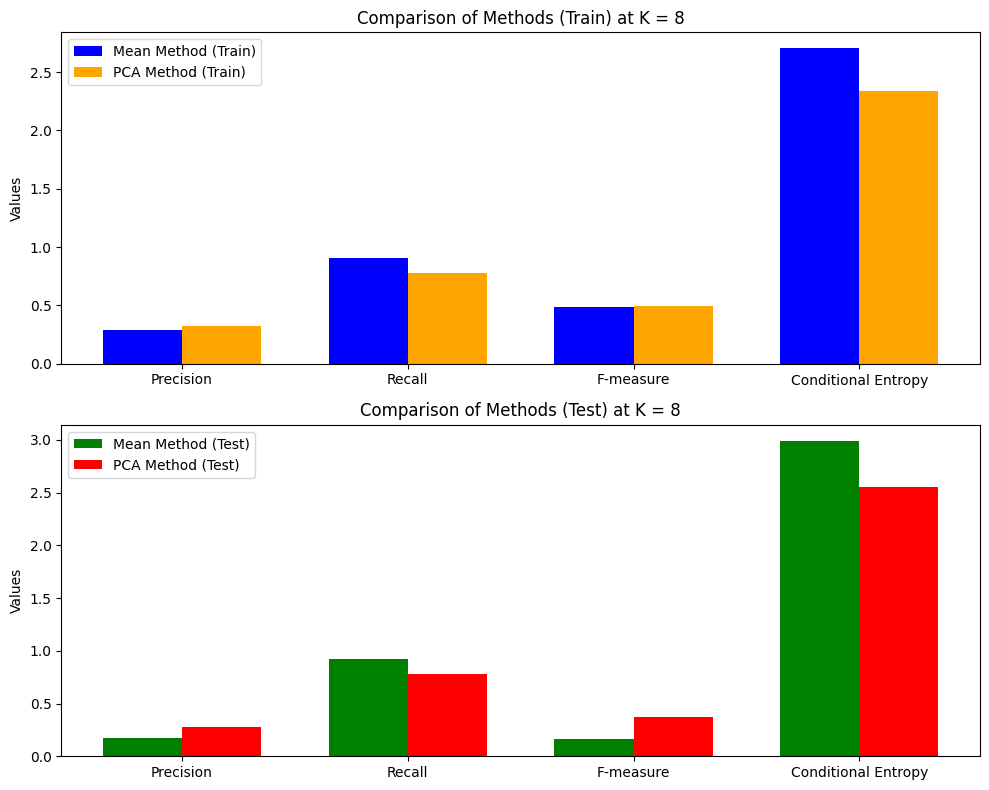

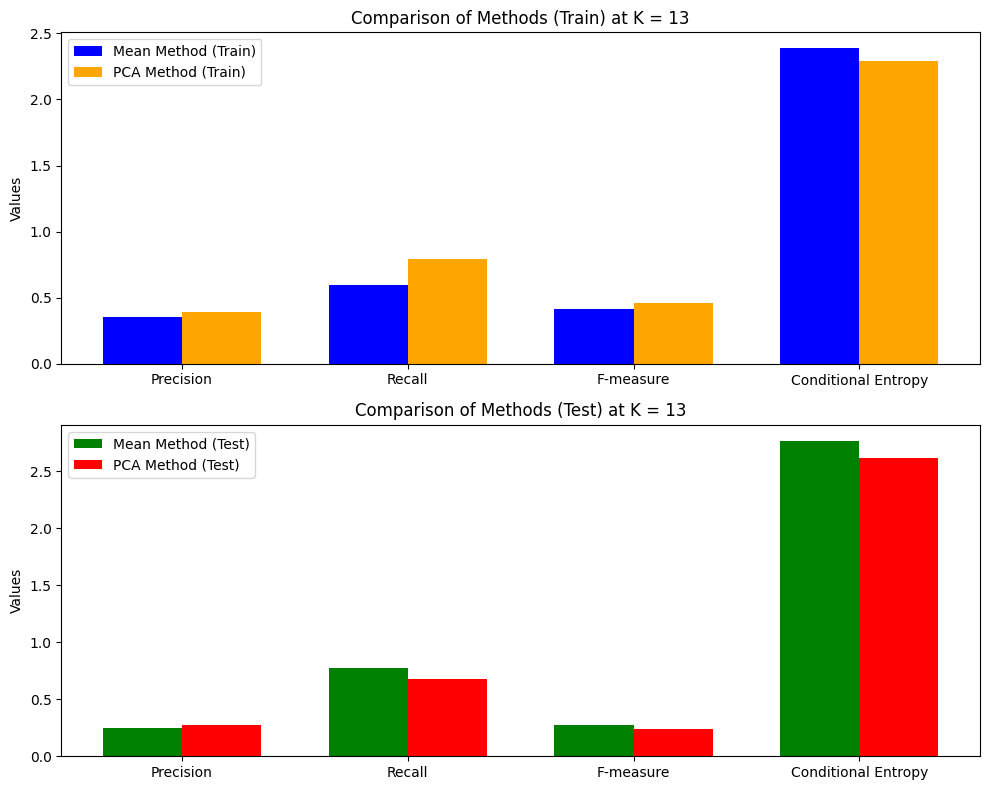

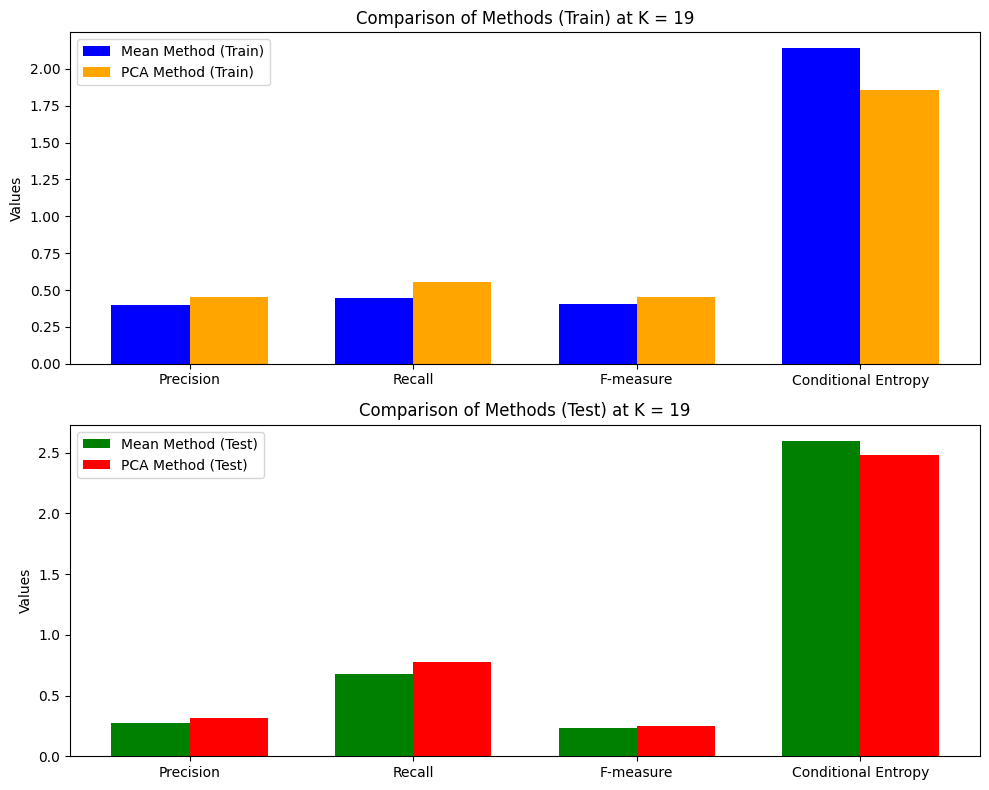

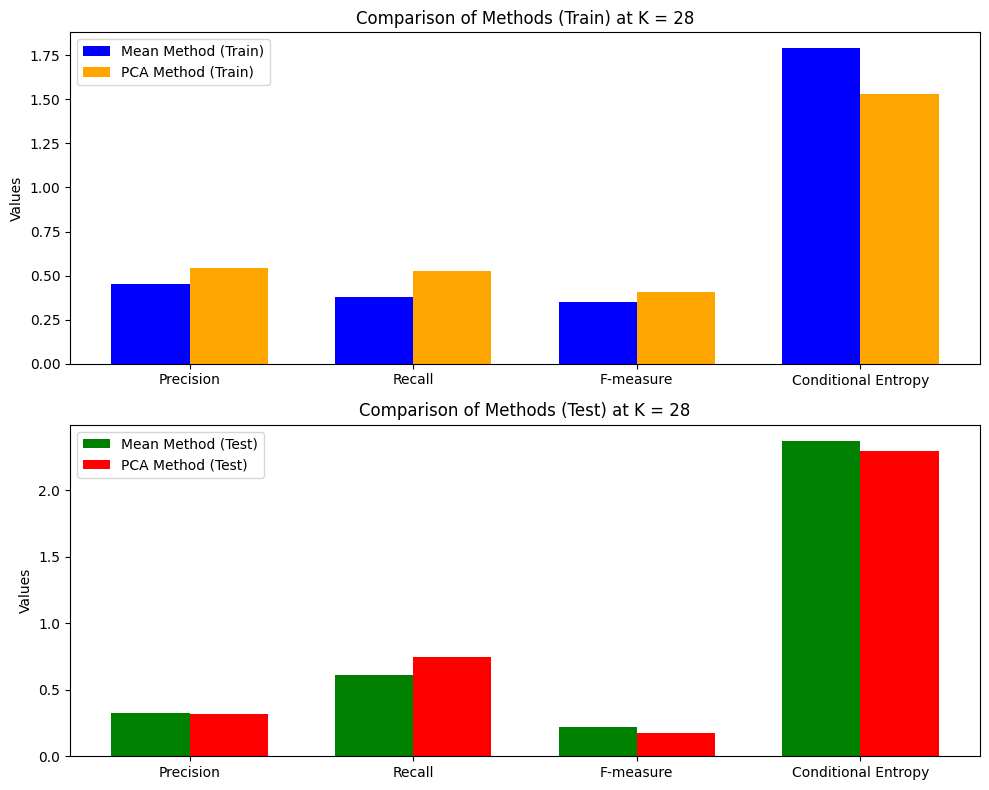

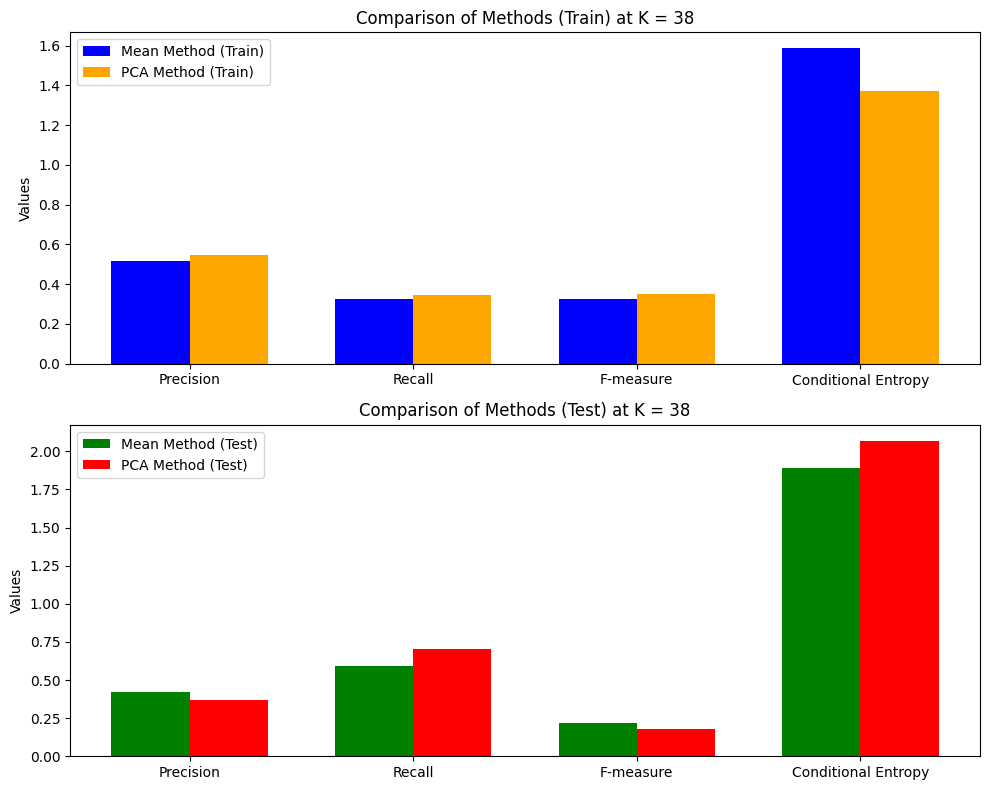

In [157]:
ks = [8, 13, 19, 28, 38]
Evaluate_and_Plot_kmeans(ks)

# Normalized Cut (Spectral Clustering)

In [ ]:
# Generating The Affinty Matrix using RBF Kernel mertrics
def rbf_kernel(X, gamma):
    pairwise_distances = squareform(pdist(X, 'sqeuclidean'))
    return np.exp(-gamma * pairwise_distances)
    # return pairwise_distances

In [ ]:
def Spectral_Clustering(X, K, gamma):
    n, d = X.shape
    # Computing the affinity matrix (using RBF kernel)
    A = rbf_kernel(X, gamma)

    # Computing The Degree matrix
    D = np.diag(np.sum(A, axis=0))

    # Normalized Laplacian Matrix
    L = D-A
    La = np.dot(np.diag(1.0 / np.diag(D)), L)

    # Get the top k smallest non-zero eigenvalues and corresponding eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(La)

    # Taking the Real Part only from the generated eigen vectors and their corresponding eigen values avoiding complex numbers
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)

    # Sorting the eigen vectors in ascending orders according to the eigen values and then taking the first K components
    sorted_indices = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[sorted_indices[:K]]
    eigenvectors = eigenvectors[:, sorted_indices[:K]]

    # Normalizing the Resulted eigen vectors
    norms = np.linalg.norm(eigenvectors, axis=1, keepdims=True)
    Y = eigenvectors / norms

    # Clustering Y using Kmeans
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(Y)  # Fit KMeans model to the data

    # Get cluster centroids and labels
    cluster_centroids = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_

    return cluster_centroids, cluster_labels

In [ ]:
K = 19
Centroids_mean_method, labels_mean_method = Spectral_Clustering(training_vector_mean_method, K, 0.0001);
print("Cluster labels 1:")
print(labels_mean_method)
Centroids_pca_method, labels_pca_method = Spectral_Clustering(training_vector_pca_method, K, 0.0001);
print("Cluster labels 2:")
print(labels_pca_method)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster labels 1:
[ 7  7  7 ...  9 13 11]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster labels 2:
[14 14 14 ... 10  1 16]


Mean Method:
precision 0.4854714912280702
recall 0.527217039587902
f_measure 0.47896151352674227
conditional entropy 1.8493535208476233
PCA Method:
precision 0.5600328947368421
recall 0.5899993718019004
f_measure 0.5566670887080525
conditional entropy 1.541143200578951


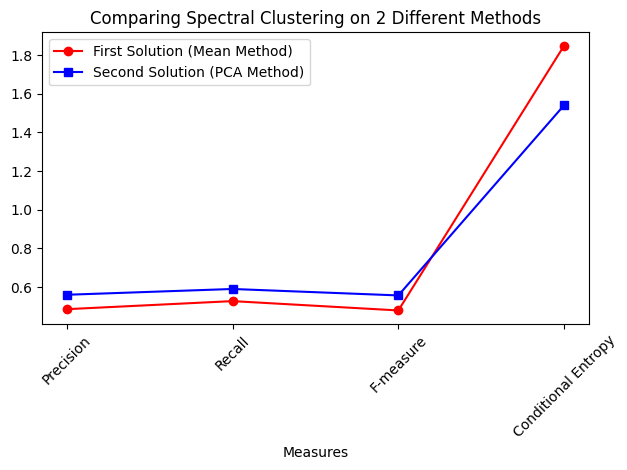

In [ ]:
Evaluate_Spectral_clustering(calculate_contingency_matrix(labels_mean_method, training_label), calculate_contingency_matrix(labels_pca_method, training_label))

# New Clustering Method (DB Scan)

### DBSCAN is a density-based algorithm that depends on density to form clusters. It takes two inputs: "eps," which refers to the minimum distance between two points, and "min_points," which refers to the number of points that should have a distance less than or equal to "eps" to consider the points as core points. The algorithm selects a core point and considers it as a cluster, and if there is another core point within the "eps" distance, it includes it in the same cluster. This algorithm can identify noise points and border points as well.


In [ ]:
def connect_density(ind, k, dist, eps, core_elements, cluster_id):
    stack = [ind]
    while stack:
        j = stack.pop()
        for neighbor in range(len(dist)):
            if dist[j][neighbor] <= eps:
                if cluster_id[neighbor] != -1:
                    continue
                cluster_id[neighbor] = k
                if neighbor in core_elements:
                    stack.append(neighbor)

def DBSCAN_algo(vector_data, min_points, eps):
    cluster_id = np.full(len(vector_data), -1)  # Initialize all points as noise
    cores = []
    distance_matrix = cdist(vector_data, vector_data)

    for i in range(len(vector_data)):
        p = 0
        elements_in_core = []
        for j in range(len(vector_data)):
            if distance_matrix[i][j] <= eps:
                p += 1

        if p >= min_points:
            cores.append(i)

    k = -1
    for i in range(len(cores)):
        if cluster_id[cores[i]] != -1:
            continue
        k += 1
        cluster_id[cores[i]] = k
        connect_density(cores[i], k, distance_matrix, eps, cores, cluster_id)
    print(cluster_id)
    return cluster_id


In [ ]:
labels1 = DBSCAN_algo(training_vector_mean_method, 7, 2.7)
labels2 = DBSCAN_algo(training_vector_pca_method, 7, 2.7)


[ 0  0  0 ... -1 -1 -1]
[ 0  0  0 ... -1 -1 -1]


Mean Method
Precision:  0.638157894736842
Recall:  0.4413116633543501
F Meausre:  0.19219949918828963
conditional Entropy:  1.3086924141560339
PCA Method
Precision:  0.6380208333333334
Recall:  0.4830736305281432
F Meausre:  0.14692531613667392
conditional Entropy:  1.4291728913490522


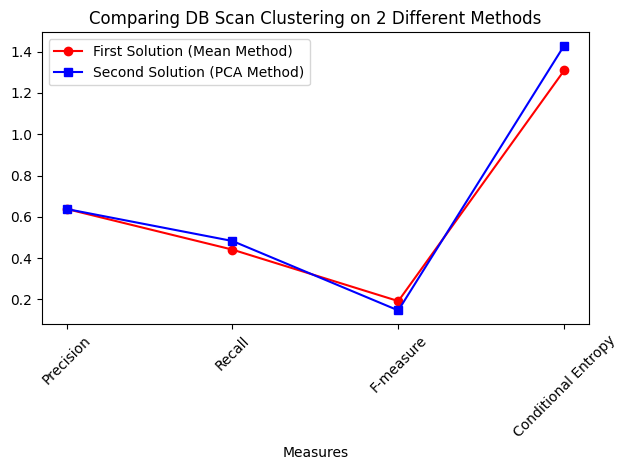

In [ ]:
  DBvariables = ['Precision', 'Recall', 'F-measure', 'Conditional Entropy']
  DBMean_Method_values = []
  DBPCA_Method_values =  []

  print("Mean Method")
  dbscan_contingency_matrix = calculate_contingency_matrix(labels1, training_label)
  prec1, rec1, f_measure1, cond_entropy1 = Evaluate_clustering(dbscan_contingency_matrix)

  print("Precision: ", prec1)
  print("Recall: ", rec1)
  print("F Meausre: ", f_measure1)
  print("conditional Entropy: ", cond_entropy1)
  DBMean_Method_values.append(prec1)
  DBMean_Method_values.append(rec1)
  DBMean_Method_values.append(f_measure1)
  DBMean_Method_values.append(cond_entropy1)


  print("PCA Method")
  dbscan_contingency_matrix2 = calculate_contingency_matrix(labels2, training_label)
  prec2, rec2, f_measure2, cond_entropy2 = Evaluate_clustering(dbscan_contingency_matrix2)

  print("Precision: ", prec2)
  print("Recall: ", rec2)
  print("F Meausre: ", f_measure2)
  print("conditional Entropy: ", cond_entropy2)
  DBPCA_Method_values.append(prec2)
  DBPCA_Method_values.append(rec2)
  DBPCA_Method_values.append(f_measure2)
  DBPCA_Method_values.append(cond_entropy2)

  plt.plot(DBvariables, DBMean_Method_values, label='First Solution (Mean Method)', marker='o', color = "red")
  plt.plot(DBvariables, DBPCA_Method_values, label='Second Solution (PCA Method)', marker='s', color = 'blue')

  # Adding labels and legend
  plt.xlabel('Measures')
  plt.title('Comparing DB Scan Clustering on 2 Different Methods')
  plt.legend()

  # Displaying the plot
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent overlapping labels
  plt.show()


***we use hyperparameter tuning to find the best eps and min points***

In [ ]:
def find_optimal_params(data):
    best_score = -1
    best_params = {}

    for min_pts in range(1, 10):  # Try different values for min_points
        for eps_val in np.linspace(0.1, 4.0, 40):  # Try different values for eps
            print(eps_val)
            cluster_labels = DBSCAN_algo(data, min_pts, eps_val)
            if len(np.unique(cluster_labels)) > 1:  # Silhouette score requires at least 2 clusters
                score = silhouette_score(data, cluster_labels)
                if score > best_score:
                    best_score = score
                    best_params['min_points'] = min_pts
                    best_params['eps'] = eps_val

    return best_params
vector_data = np.concatenate((training_vector_mean_method, test_vector_mean_method))
# Usage example
best_params = find_optimal_params(vector_data)
print("Best Parameters:", best_params)

0.1
[ 0  0  0 ... -1 95 95]
0.2
[ 0  0  0 ... -1 95 95]
0.3
[ 0  0  0 ... -1 95 95]
0.4
[ 0  0  0 ... -1 95 95]
0.5
[ 0  0  0 ... -1 95 95]
0.6
[ 0  0  0 ... -1 95 95]
0.7
[ 0  0  0 ... -1 95 95]
0.7999999999999999
[ 0  0  0 ... -1 95 95]
0.8999999999999999
[ 0  0  0 ... -1 95 95]
0.9999999999999999
[ 0  0  0 ... -1 95 95]
1.0999999999999999
[ 0  0  0 ... -1 95 95]
1.2
[ 0  0  0 ... -1 95 95]
1.3
[ 0  0  0 ... -1 95 95]
1.4
[ 0  0  0 ... -1 95 95]
1.5
[ 0  0  0 ... -1 95 95]
1.5999999999999999
[ 0  0  0 ... -1 95 95]
1.7
[ 0  0  0 ... -1 95 95]
1.8
[ 0  0  0 ... -1 95 95]
1.9
[ 0  0  0 ... -1 95 95]
2.0
[ 0  0  0 ... -1 95 95]
2.0999999999999996
[ 0  0  0 ... -1 95 95]
2.1999999999999997
[ 0  0  0 ... -1 95 95]
2.3
[ 0  0  0 ... -1 95 95]
2.4
[ 0  0  0 ... -1 95 95]
2.5
[ 0  0  0 ... -1 95 95]
2.6
[ 0  0  0 ... -1 95 95]
2.6999999999999997
[ 0  0  0 ... -1 95 95]
2.8
[ 0  0  0 ... -1 95 95]
2.9
[ 0  0  0 ... -1 95 95]
3.0
[ 0  0  0 ... -1 95 95]
3.0999999999999996
[ 0  0  0 ... -1 95 9

# ***Comparison***


1. Kmeans is a centroid based algorithm that needs the no of clusers to be initalized and the data has to be spherical for it to work correctly and it is sensitive for outliers and noise, it is often becomes more precise due to normalization.
2. Normalized cut is a graph-based algorithm it doesn't need initialization it can work with data of irregular shape and handle outlier and noise it less efficient for large dataset.
3.DBSCAN algorithm is a density-based algorithm that does not require predefining cluster but require initalizing eps and minimum points, it can handle data of irregular shape, it can handle outliers and noise, also it is efficient for large datasets